In [126]:
import os, sys
from pathlib import Path

from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

load_dotenv()

sys.path.insert(0, os.getenv("repo_path"))

from Methods.video_tracking import loading as vload


In [104]:
data_dir = Path(os.getenv("local_home")) / "Task_Switching/head_tracking"
log_file = '2023-03-04_DLC_alignSyncInterp_15-35-41.log'

with open( data_dir / log_file) as f:
    log_info = f.read().splitlines()

print(log_info.pop(0))      # threshold settings
print(log_info.pop(0))      # interpolation settings


2023-03-04 15:35:41,996 - INFO - Threshold for removing data = 0.6
2023-03-04 15:35:42,004 - INFO - Interpolation settings: {'method': 'linear', 'limit_direction': 'both', 'limit_area': 'inside'}


In [159]:
data = []

for line in log_info:

    [dt, state, msg] = line.split(' - ')
    msg_parts = msg.split(' ')

    # Strip details about current block
    if 'interpolation limit' in  line:
        current_ferret = int(msg_parts[1][1:])
        current_block = msg_parts[2].replace('Block_','').replace(':','')
        
    # Strip details about current landmark and amount of missing data
    elif "masked" in line:
        
        data.append({
            'ferret': current_ferret,
            'block': current_block,
            'landmark': msg_parts[0].replace(':',''),
            'n_missing': int(msg_parts[1]),
            'n_total': int(msg_parts[3])
        })

df = pd.DataFrame(data)
df = df.assign(percent_missing = lambda x: (x.n_missing / x.n_total) * 100)
df.head(4)

,ferret,block,landmark,n_missing,n_total,percent_missing
0,1605,J5-20,red_LED,1945,24004,8.102816
1,1605,J5-20,blue_LED,1784,24004,7.432095
2,1605,J5-20,nose,2814,24004,11.723046
3,1605,J5-20,head,1334,24004,5.557407


Let's start by getting an overview on the distribution of low_likelihood data across sessions for each landmark. Interestingly, the most reliable landmark isn't on the head, but the shoulders, which makes sense in terms of being more visible when the animal is at the response port. There isn't a huge amount of difference with the head landmark (as we'll see below when looking at the correlations between landmarks) but the shoulders are a potential site of interest if we want to recover low exposure videos without LEDs.

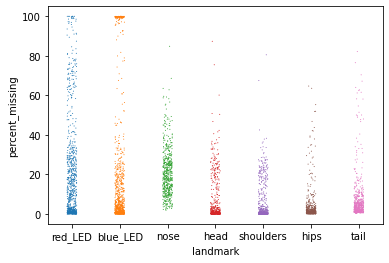

In [84]:
sns.stripplot(
    data = df,
    x = 'landmark',
    y = 'percent_missing',
    s = 1
)

plt.show()

In [60]:
prc_missing = df.pivot(index=['ferret','block'], columns="landmark", values="percent_missing")
prc_missing = prc_missing.fillna(100)

prc_missing.head(3)

landmark        blue_LED   head   hips   nose   red_LED  shoulders   tail
ferret block                                                             
1506   J1-17:  37.864218  100.0  100.0  100.0  2.674230      100.0  100.0
       J1-19:  11.488222  100.0  100.0  100.0  0.923858      100.0  100.0
       J1-20:  10.474175  100.0  100.0  100.0  1.029226      100.0  100.0

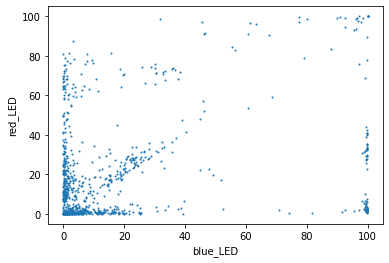

In [62]:
prc_missing.plot.scatter(x='blue_LED', y='red_LED', s=1)

plt.show()

<AxesSubplot:xlabel='n_total', ylabel='percent_missing'>

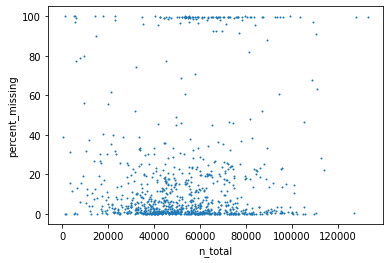

In [73]:
df.query("landmark == 'blue_LED'").plot.scatter(x='n_total', y='percent_missing', s=1)

In [75]:
# Look at the correlation matrices between landmarks for videos with all landmarks
prc_missing.query("head < 99").corr()

landmark,blue_LED,head,hips,nose,red_LED,shoulders,tail
landmark,,,,,,,
blue_LED,1.000000,0.867828,0.297080,0.563071,0.541113,0.784552,0.359343
head,0.867828,1.000000,0.298677,0.599273,0.552060,0.946387,0.336395
hips,0.297080,0.298677,1.000000,0.174611,0.129859,0.379531,0.937169
nose,0.563071,0.599273,0.174611,1.000000,0.337893,0.542707,0.196539
red_LED,0.541113,0.552060,0.129859,0.337893,1.000000,0.467897,0.233587
shoulders,0.784552,0.946387,0.379531,0.542707,0.467897,1.000000,0.401002
tail,0.359343,0.336395,0.937169,0.196539,0.233587,0.401002,1.000000


In [118]:
# Look at the correlation matrices between landmarks for videos with all landmarks
led_only_index = prc_missing.query("head == 100").index
prc_missing.loc[led_only_index, ['blue_LED','red_LED']].corr()

landmark,blue_LED,red_LED
landmark,,
blue_LED,1.000000,0.304872
red_LED,0.304872,1.000000


Note that the correlation between LEDs is higher in high exposure than low exposure videos, reflecting the fact that low exposure videos are more likely to only have one LED active (though which one varies between frames)

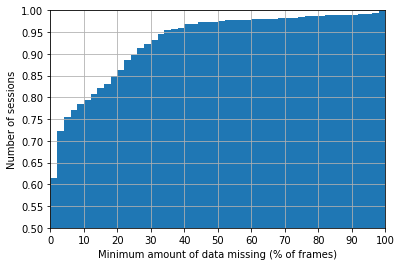

In [134]:
# What is the minimum amount of missing data across key landmarks of interest
key_landmarks = ['red_LED','blue_LED','head']

min_missing = prc_missing[key_landmarks].min(axis=1)
min_missing = min_missing.sort_values(ascending=False)

min_missing.hist(bins=50, cumulative=True, density=True)
plt.xticks(np.arange(0, 110, 10))
plt.yticks(np.arange(0.5, 1.1, 0.05))
plt.xlabel('Minimum amount of data missing (% of frames)')
plt.ylabel('Number of sessions')
plt.xlim((0,100))
plt.ylim((0.5, 1.0))
plt.show()

But who are these sessions with >80% of the data missing? 

It turns out that these are mostly low exposure videos recorded when the animal was not plugged into the recording system. There are thus no LEDs to track, and the video is too dark for reliable monitorring of head position (running the high exposure tracking model on low exposure images gives good results near the central spout, but systematically struggles away from the spout).

There is a smaller group of videos in which the LEDs are set to flash rather than remain on constantly (F1506 and F1518 in particular) and this leads to a lot of lost data. It's not clear if these should be removed or just ignored.

We can therefore just drop these blocks from the data.

In [119]:
min_missing.head(10)

ferret  block 
1607    J3-45:    100.000000
        J3-51:    100.000000
        J3-39:    100.000000
        J3-42:    100.000000
1613    J3-49:    100.000000
1607    J3-84:     99.996384
        J3-46:     97.270721
        J3-47:     93.595681
        J3-52:     92.976059
1506    J2-11:     89.410378
dtype: float64

In [140]:
min_missing = min_missing[min_missing < 70]
min_missing.head(20)

ferret  block 
1506    J2-30:    68.725673
1607    J3-26:    67.575705
1613    J5-24:    60.153306
1607    J3-96:    59.013769
1605    J5-3:     53.673458
1613    J3-15:    50.834929
1607    J3-18:    50.395077
1602    J2-41:    46.783070
1506    J1-28:    46.354274
1607    J5-12:    45.901576
        J3-32:    44.859154
1518    J2-37:    44.106082
        J2-27:    42.365216
1613    J4-24:    41.570275
1518    J2-29:    41.166328
        J2-26:    41.165865
1602    J2-49:    40.618245
1613    J4-27:    40.458189
1518    J2-25:    40.227373
        J2-22:    40.119886
dtype: float64

In [163]:
df.query("ferret == 1607 and block == 'J3-19'")

,ferret,block,landmark,n_missing,n_total,percent_missing
3228,1607,J3-19,red_LED,106436,111016,95.874469
3229,1607,J3-19,blue_LED,70441,111016,63.451214
3230,1607,J3-19,nose,49066,111016,44.197233
3231,1607,J3-19,head,29221,111016,26.321431
3232,1607,J3-19,shoulders,15042,111016,13.549398
3233,1607,J3-19,hips,10824,111016,9.749946
3234,1607,J3-19,tail,25495,111016,22.965158


In [113]:
# What does missing data look like in the resulting file
dlc_results = 'DLC_alignSyncInterp_230304_1535.parquet'

bad_block = vload.load_parquet(data_dir/dlc_results, fnum=1607, block='J3-52')
bad_block.shape

(41686, 25)

In [115]:
bad_block.iloc[10]

fnum                       1607
block                     J3-52
red_LEDx                    NaN
red_LEDy                    NaN
red_LEDlikelihood      0.000588
blue_LEDx                   NaN
blue_LEDy                   NaN
blue_LEDlikelihood     0.000261
nosex                       0.0
nosey                       0.0
noselikelihood              0.0
headx                       0.0
heady                       0.0
headlikelihood              0.0
shouldersx                  0.0
shouldersy                  0.0
shoulderslikelihood         0.0
hipsx                       0.0
hipsy                       0.0
hipslikelihood              0.0
tailx                       0.0
taily                       0.0
taillikelihood              0.0
frame                        10
time                   0.433333
Name: 10, dtype: object